In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

objc[66545]: Class CaptureDelegate is implemented in both /Users/kevynkrancenblum/.local/lib/python3.9/site-packages/cv2/cv2.abi3.so (0x2895824e8) and /Users/kevynkrancenblum/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/mediapipe/.dylibs/libopencv_videoio.3.4.16.dylib (0x140588860). One of the two will be used. Which one is undefined.
objc[66545]: Class CVWindow is implemented in both /Users/kevynkrancenblum/.local/lib/python3.9/site-packages/cv2/cv2.abi3.so (0x289582538) and /Users/kevynkrancenblum/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (0x1302a0a68). One of the two will be used. Which one is undefined.
objc[66545]: Class CVView is implemented in both /Users/kevynkrancenblum/.local/lib/python3.9/site-packages/cv2/cv2.abi3.so (0x289582560) and /Users/kevynkrancenblum/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (0x1302a0a90). One of the two will

In [3]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [2]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [22]:
def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [67]:
import os

start = 0
end = 29
for i in range(start, end+1):
    current_folder_name = '/Users/kevynkrancenblum/Desktop/Data Science/Final Project/Body_Language_recognition/KeypointsData/Sad2/Sad2/' + str(i)
    new_folder_name = '/Users/kevynkrancenblum/Desktop/Data Science/Final Project/Body_Language_recognition/KeypointsDataVideo/Sad/'+ str(i + 452)
    os.rename(current_folder_name, new_folder_name)
    #current_folder_name = '/Users/kevynkrancenblum/Desktop/Data Science/Final Project/Body_Language_recognition/KeypointsData30f copy/Sad/Sad1' + str(i)
    #new_folder_name = '/Users/kevynkrancenblum/Desktop/Data Science/Final Project/Body_Language_recognition/KeypointsData/Keypoints/Sad/'+ str(i + 240)
    #os.rename(current_folder_name, new_folder_name)
    #current_folder_name = '/Users/kevynkrancenblum/Desktop/Data Science/Final Project/Body_Language_recognition/KeypointsData30f copy/Angry/Angry1' + str(i)
    #new_folder_name = '/Users/kevynkrancenblum/Desktop/Data Science/Final Project/Body_Language_recognition/KeypointsData/Keypoints/Angry/'+ str(i + 240)
    #os.rename(current_folder_name, new_folder_name)

In [4]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose,face, lh, rh])

In [6]:
DATA_PATH = os.path.join('/Users/kevynkrancenblum/Desktop/Data Science/Final Project/Body_Language_recognition/KeypointsDataVideo') 

# Actions that we try to detect
actions = np.array(['Angry', 'Happy','Sad'])

# Thirty videos worth of data
no_sequences = 481

# Videos are going to be 30 frames in length
sequence_length = 30

In [5]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [7]:
label_map = {label:num for num, label in enumerate(actions)}

In [69]:
sequences, labels = [], []
for action in actions:
    if action == 'Sad':
        for sequence in range(no_sequences):
            window = []
            for frame_num in range(sequence_length):
                res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
                window.append(res)
            sequences.append(window)
            labels.append(label_map[action])
    elif action == 'Angry':
        for sequence in range(362):
            window = []
            for frame_num in range(sequence_length):
                res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
                window.append(res)
            sequences.append(window)
            labels.append(label_map[action])
    else:
        for sequence in range(592):
            window = []
            for frame_num in range(sequence_length):
                res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
                window.append(res)
            sequences.append(window)
            labels.append(label_map[action])

In [8]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)
X.shape

NameError: name 'sequences' is not defined

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Activation
from tensorflow.keras.callbacks import TensorBoard
from keras import regularizers

In [10]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.regularizers import L2

input_shape = (30, 1662)

model = Sequential()

# CNN layers
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv1D(256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# GRU layers
model.add(GRU(256, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(GRU(128, return_sequences=False))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu', activity_regularizer=L2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', activity_regularizer=L2(0.01)))

model.add(Dense(actions.shape[0], activation='softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-05-18 02:38:26.107790: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-18 02:38:26.107936: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
model.summary()

NameError: name 'model' is not defined

In [75]:
model.fit(X_train, y_train, epochs=500, callbacks=[tb_callback])

Epoch 1/500


2023-04-08 16:43:21.387222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-08 16:43:21.947327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-08 16:43:22.053536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-08 16:43:22.338509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-08 16:43:22.540083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 6s 82ms/step - loss: 2.0224 - categorical_accuracy: 0.4343
Epoch 2/500
43/43 [==============================] - 2s 45ms/step - loss: 1.4767 - categorical_accuracy: 0.4908
Epoch 3/500
43/43 [==============================] - 2s 43ms/step - loss: 1.2902 - categorical_accuracy: 0.5055
Epoch 4/500
43/43 [==============================] - 2s 44ms/step - loss: 1.1587 - categorical_accuracy: 0.5525
Epoch 5/500
43/43 [==============================] - 2s 45ms/step - loss: 1.1078 - categorical_accuracy: 0.5583
Epoch 6/500
43/43 [==============================] - 2s 45ms/step - loss: 1.0426 - categorical_accuracy: 0.5884
Epoch 7/500
43/43 [==============================] - 2s 44ms/step - loss: 1.0069 - categorical_accuracy: 0.6141
Epoch 8/500
43/43 [==============================] - 2s 45ms/step - loss: 0.9451 - categorical_accuracy: 0.6288
Epoch 9/500
43/43 [==============================] - 2s 44ms/step - loss: 0.9312 - categorical_accuracy: 0.6398
Epoc

In [76]:
model.save('actiontest.h5')

In [15]:
model.load_weights('/Users/kevynkrancenblum/Desktop/Data Science/Final Project/Body_Language_recognition/actiontest.h5')

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/Users/kevynkrancenblum/Desktop/Data Science/Final Project/Body_Language_recognition/actiontest.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [78]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
cm=multilabel_confusion_matrix(ytrue, yhat)

2023-04-08 16:59:49.251057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/3 [=========>....................] - ETA: 1s

2023-04-08 16:59:49.460930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-08 16:59:49.526326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 189ms/step


In [79]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

3/3 [==============================] - 0s 12ms/step


Class 0
True Positives: 12
True Negatives: 48
False Positives: 6
False Negatives: 6

Class 1
True Positives: 32
True Negatives: 33
False Positives: 6
False Negatives: 1

Class 2
True Positives: 12
True Negatives: 47
False Positives: 4
False Negatives: 9



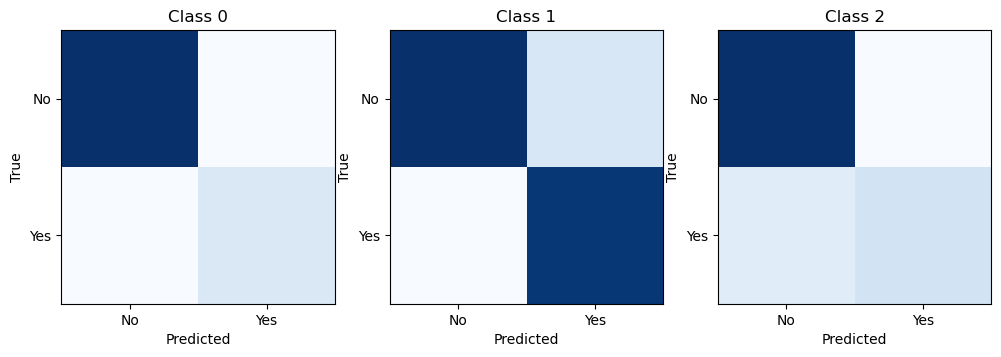

In [80]:
# Calculate the true positives, true negatives, false positives, and false negatives for each class
tn = cm[:, 0, 0]
fp = cm[:, 0, 1]
fn = cm[:, 1, 0]
tp = cm[:, 1, 1]

# Print the evaluation metrics for each class
for i in range(len(action)):
    print('Class', i)
    print('True Positives:', tp[i])
    print('True Negatives:', tn[i])
    print('False Positives:', fp[i])
    print('False Negatives:', fn[i])
    print()

# Plot the confusion matrices for each class
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i in range(len(action)):
    axs[i].imshow(cm[i], cmap='Blues')
    axs[i].set_title('Class ' + str(i))
    axs[i].set_xlabel('Predicted')
    axs[i].set_ylabel('True')
    tick_marks = np.arange(2)
    axs[i].set_xticks(tick_marks)
    axs[i].set_yticks(tick_marks)
    axs[i].set_xticklabels(['No', 'Yes'])
    axs[i].set_yticklabels(['No', 'Yes'])
plt.show()

In [38]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [39]:
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture("/Users/kevynkrancenblum/Desktop/Data Science/Final Project/VideoBody/Angry/BasmaAngryy.mp4")
#cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)

        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            if res[np.argmax(res)] > threshold: 
                predictions.append(np.argmax(res))
            
            
        #3. Viz logic
        if len(predictions) > 0:
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


1/1 [==============================] - 0s 130ms/step
Angry
1/1 [==============================] - 0s 20ms/step
Angry
1/1 [==============================] - 0s 19ms/step
Angry
1/1 [==============================] - 0s 17ms/step
Angry
1/1 [==============================] - 0s 17ms/step
Angry
1/1 [==============================] - 0s 18ms/step
Angry
1/1 [==============================] - 0s 17ms/step
Angry
1/1 [==============================] - 0s 17ms/step
Happy
1/1 [==============================] - 0s 17ms/step
Angry
1/1 [==============================] - 0s 17ms/step
Angry
1/1 [==============================] - 0s 17ms/step
Angry
1/1 [==============================] - 0s 18ms/step
Angry
1/1 [==============================] - 0s 17ms/step
Angry
1/1 [==============================] - 0s 17ms/step
Angry
1/1 [==============================] - 0s 17ms/step
Angry
1/1 [==============================] - 0s 17ms/step
Angry
1/1 [==============================] - 0s 16ms/step
Angry
1/1 [========

In [34]:
sequence = []
sentence = []
predictions = []
threshold = 0.6

#cap = cv2.VideoCapture(0)
cap = cv2.VideoCapture("/Users/kevynkrancenblum/Desktop/Data Science/Final Project/VideoBody/sad/avitalsad1.mp4")
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        black_screen = np.zeros((image.shape[0], image.shape[1], 3), np.uint8)
        # Draw landmarks
        draw_styled_landmarks(black_screen, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            if res[np.argmax(res)] > threshold: 
                predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, black_screen, colors)
            
        cv2.rectangle(black_screen, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(black_screen, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', black_screen)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

1/1 [==============================] - 0s 28ms/step
Sad
1/1 [==============================] - 0s 17ms/step
Sad
1/1 [==============================] - 0s 16ms/step
Sad
1/1 [==============================] - 0s 17ms/step
Sad
1/1 [==============================] - 0s 18ms/step
Sad
1/1 [==============================] - 0s 17ms/step
Sad
1/1 [==============================] - 0s 17ms/step
Sad
1/1 [==============================] - 0s 17ms/step
Sad
1/1 [==============================] - 0s 17ms/step
Sad
1/1 [==============================] - 0s 17ms/step
Sad
1/1 [==============================] - 0s 18ms/step
Sad
1/1 [==============================] - 0s 19ms/step
Sad
1/1 [==============================] - 0s 17ms/step
Sad
1/1 [==============================] - 0s 17ms/step
Sad
1/1 [==============================] - 0s 18ms/step
Sad
1/1 [==============================] - 0s 17ms/step
Sad
1/1 [==============================] - 0s 16ms/step
Sad
1/1 [==============================] - 0s 17ms/s